In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

/scratch/midway3/jshe/.conda/envs/proppred/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
data_path = '../data/immunomodulation/log_normalized/regression/'

In [3]:
# Unimol Embeddings
train_X = np.load(data_path + 'train/unimol_embeddings.npy')
validation_X = np.load(data_path + 'validation/unimol_embeddings.npy')
test_X = np.load(data_path + 'test/unimol_embeddings.npy')

In [4]:
train_Y = pd.read_csv(data_path + 'train/y.csv').iloc[:, 0]
validation_Y = pd.read_csv(data_path + 'validation/y.csv').iloc[:, 0]
test_Y = pd.read_csv(data_path + 'test/y.csv').iloc[:, 0]

train_STD = pd.read_csv(data_path + 'train/std.csv')
validation_STD = pd.read_csv(data_path + 'validation/std.csv')
test_STD = pd.read_csv(data_path + 'test/std.csv')

In [5]:
# Convert data to Tensors
train_X = torch.tensor(train_X, dtype=torch.float32).detach().to(device)
validation_X = torch.tensor(validation_X, dtype=torch.float32).detach().to(device)
test_X = torch.tensor(test_X, dtype=torch.float32).detach().to(device)

train_Y = torch.tensor(train_Y.to_numpy(), dtype=torch.float32).detach().to(device)
validation_Y = torch.tensor(validation_Y.to_numpy(), dtype=torch.float32).detach().to(device)
test_Y = torch.tensor(test_Y.to_numpy(), dtype=torch.float32).detach().to(device)

train_Var = torch.tensor(train_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2
validation_Var = torch.tensor(validation_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2
test_Var = torch.tensor(test_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2

## Model

In [6]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.ReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output

        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma ** 2), obs=y)
        
        return mu

## Train

In [12]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange

pyro.clear_param_store()

model = BNN(in_dim=512, out_dim=1, hid_dim=32, n_hid_layers=2, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.0001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())

pyro.clear_param_store()

progress_bar = trange(2048)
for epoch in progress_bar:
    loss = svi.step(train_X, train_Y)
    progress_bar.set_postfix(loss=f"{loss / train_X.shape[0]:.3f}")

 35%|████████▊                | 725/2048 [00:06<00:11, 110.32it/s, loss=128.460]


KeyboardInterrupt: 

## Visualization

In [9]:
test_predictions = model(test_X).detach()

"\nfig, axs = plt.subplots(3, 3, figsize=(9, 9))\naxs = axs.flatten()\n\nfor i, property_label in enumerate(properties):\n\n    ax = axs[i]\n\n    ax.scatter(test_Y[:, i].cpu(), test_predictions[:, i].cpu(), s=2)\n    ax.set_xlabel('Actual')\n    ax.set_ylabel('Predicted')\n    ax.set_title(property_label)\n    ax.set_aspect('equal', adjustable='datalim')\n\nplt.tight_layout()\n"

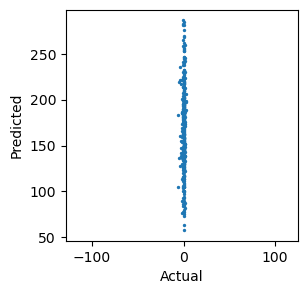

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(test_Y.cpu(), test_predictions.cpu(), s=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_aspect('equal', adjustable='datalim')

'''
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y[:, i].cpu(), test_predictions[:, i].cpu(), s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
'''